# ANTs QC Pipeline
Cleaned workflow that wraps the reusable `antsQC` module. Fill in the parameters below, run the pipeline, and explore the registered outputs.

In [6]:
from pathlib import Path
from antsQC import Spacing, TransformConfig, PipelineConfig

# --- Input files ---------------------------------------------------------
CONF_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_round1_channel2_cort_gauss_seg_20251006.npy"   # path to confocal *_seg.npy
TWOP_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy"       # path to 2P *_seg.npy

# Optional: intensity volumes used during registration (set to None if unavailable)
CONF_INTENSITY = None  # e.g., Path("/path/to/confocal_intensity.nrrd")
TWOP_INTENSITY = None  # e.g., Path("/path/to/twop_intensity.nrrd")

# --- Spacing metadata (µm); update using imaging metadata -----------------
VOX_CONF = Spacing(dz=1.0, dy=0.2075665, dx=0.2075665)
VOX_TWOP = Spacing(dz=2.0, dy=0.6506220, dx=0.6506220)

# --- Transform list (moving -> fixed) ------------------------------------
# Include the non-linear warp BEFORE any affine.
ANTs_TRANSFORMS = TransformConfig([
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz",          # example SyN warp, forward transformation
    # "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1InverseWarp.nii.gz"    , # example SyN warp, inverse transformation
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat"     # example affine
])

# --- Matching parameters -------------------------------------------------
MATCH_METHOD = "nn"  # choose 'nn' or 'hungarian'
MAX_DISTANCE_UM = 5.0

# --- Output directory ----------------------------------------------------
OUTPUT_DIR = Path(".")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONFIG = PipelineConfig(
    confocal_seg=CONF_SEG_NPY,
    twop_seg=TWOP_SEG_NPY,
    confocal_spacing=VOX_CONF,
    twop_spacing=VOX_TWOP,
    transforms=ANTs_TRANSFORMS,
    match_method=MATCH_METHOD,
    max_distance_um=MAX_DISTANCE_UM,
    confocal_intensity=CONF_INTENSITY,
    twop_intensity=TWOP_INTENSITY,
)


In [7]:
from antsQC import AntsPyNotAvailableError, run_pipeline
import pandas as pd
import numpy as np

OUTPUT_FILES = {
    "overview_csv": OUTPUT_DIR / "input_datasets_overview.csv",
    "matches_csv": OUTPUT_DIR / "centroid_matches.csv",
    "summary_json": OUTPUT_DIR / "qc_summary.json",
    "warped_mask": OUTPUT_DIR / "confocal_labels_in_2P_space.npy",
}

try:
    RESULT = run_pipeline(
        CONFIG,
        save_overview_csv=OUTPUT_FILES["overview_csv"],
        save_matches_csv=OUTPUT_FILES["matches_csv"],
        save_summary_json=OUTPUT_FILES["summary_json"],
        save_warped_mask=OUTPUT_FILES["warped_mask"],
    )
except AntsPyNotAvailableError as exc:
    print("ANTsPy is required for warp and point transforms.")
    raise

RESULT


PipelineResult(config=PipelineConfig(confocal_seg=PosixPath('/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_round1_channel2_cort_gauss_seg_20251006.npy'), twop_seg=PosixPath('/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy'), confocal_spacing=Spacing(dy=0.2075665, dx=0.2075665, dz=1.0), twop_spacing=Spacing(dy=0.650622, dx=0.650622, dz=2.0), transforms=TransformConfig(paths=['/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz', '/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat'], invert_flags=None, invert_affine=True), match_method='nn', max_distance_um=5.0, random_seed=42, confocal_intensity=None, twop_intensity=None), overview=          dataset                                               file  \
0  Confocal (HCR)  L427_f02_round1_channel2_cort_gauss_s

In [8]:
RESULT.overview


,dataset,file,path,exists,size_MB,modified,shape,ndim,dtype,min_label,max_label,n_cells,nonzero_voxels,frac_nonzero_pct,voxel_um,FOV_um,n_voxels,anisotropy_z_over_y
0,Confocal (HCR),L427_f02_round1_channel2_cort_gauss_seg_202510...,/Users/ddharmap/dataProcessing/2p_HCR/data/L42...,True,16252.932,2025-10-15 07:15:07,"(155, 2048, 2048)",3,uint16,0,191,191,850366,0.1308,"(1.0, 0.2075665, 0.2075665)","(155.0, 425.096, 425.096)",650117120,4.817733
1,2P (mCherry),L427_f02_anatomy_2P_cort_seg_anis1.npy,/Users/ddharmap/dataProcessing/2p_HCR/data/L42...,True,2756.266,2025-10-06 09:32:37,"(196, 750, 750)",3,uint16,0,939,939,322698,0.2927,"(2.0, 0.650622, 0.650622)","(392.0, 487.967, 487.967)",110250000,3.073982


In [9]:
pd.DataFrame([RESULT.match_summary])


,N_total,N_within_gate,frac_within_gate,median_um,p90_um,method,max_distance_um
0,191,0,0.0,NaN,NaN,nn,5.0


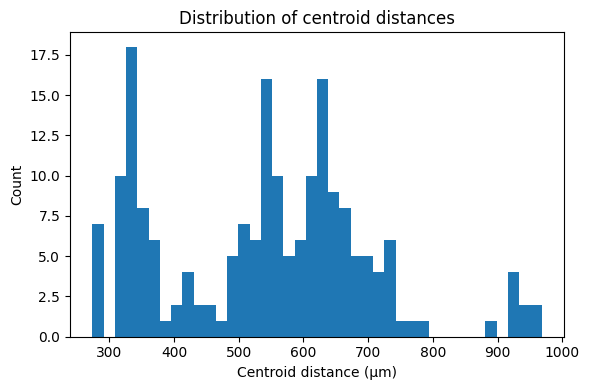

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(RESULT.matches["distance_um"], bins=40)
ax.set_xlabel("Centroid distance (µm)")
ax.set_ylabel("Count")
ax.set_title("Distribution of centroid distances")
fig.tight_layout()


interactive(children=(FloatSlider(value=333.2003173828125, description='z_um', max=825.4090576171875, min=102.…

<function __main__._plot_slice(z_um=0.0, thickness_um=4.0, show_conf=True, show_2p=True)>

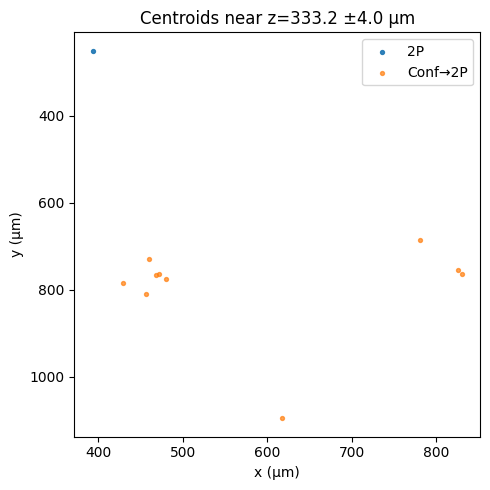

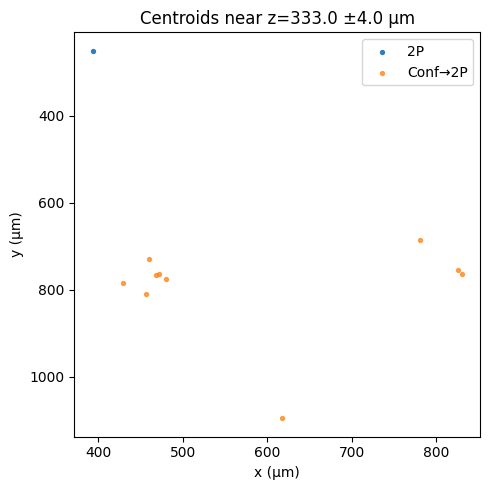

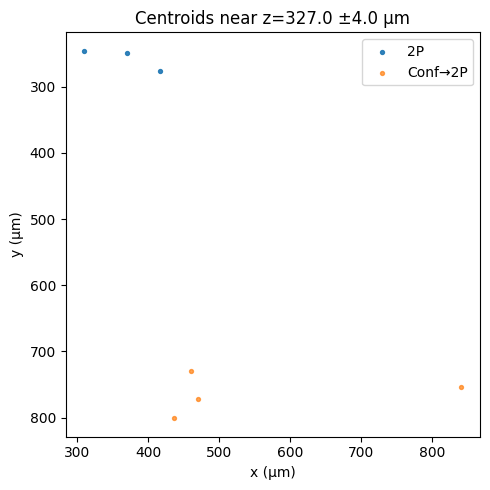

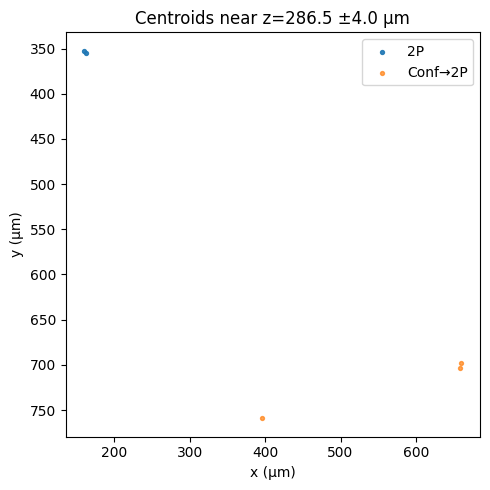

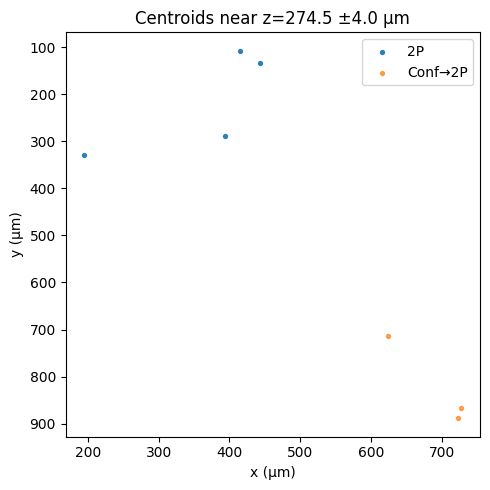

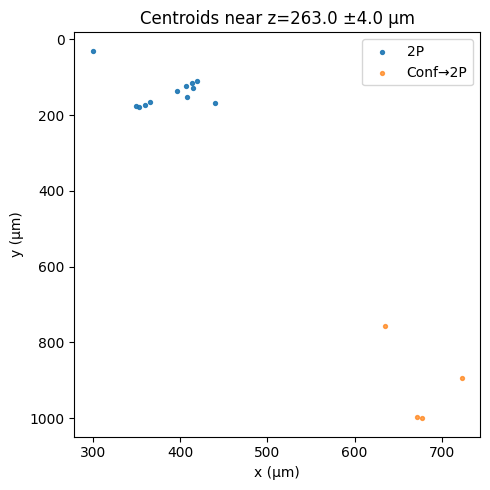

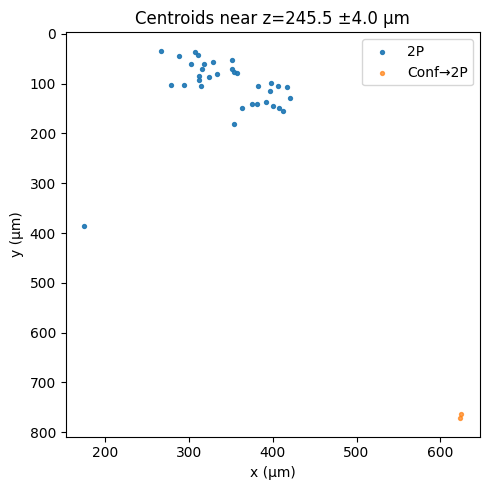

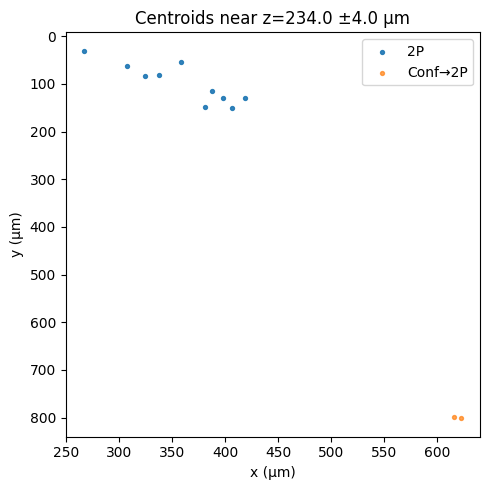

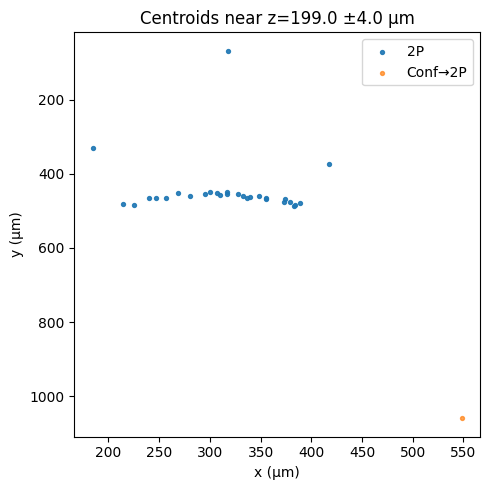

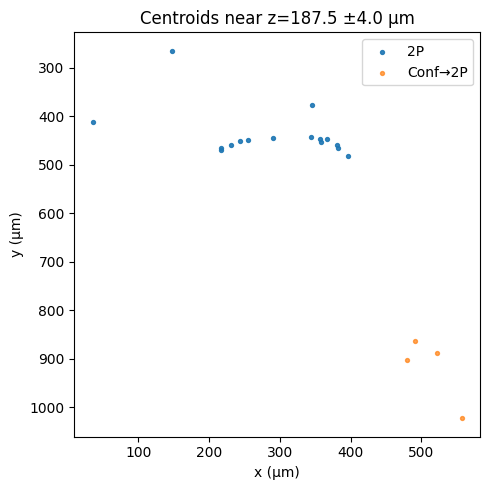

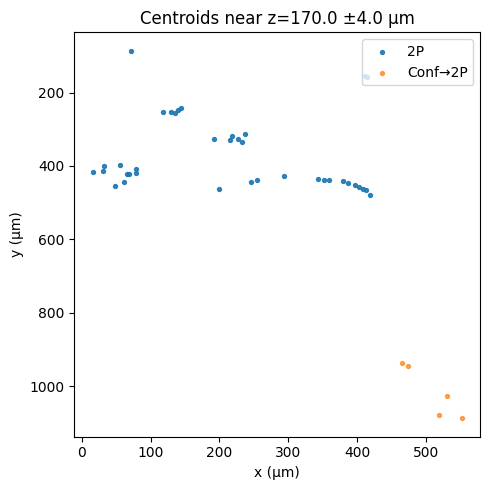

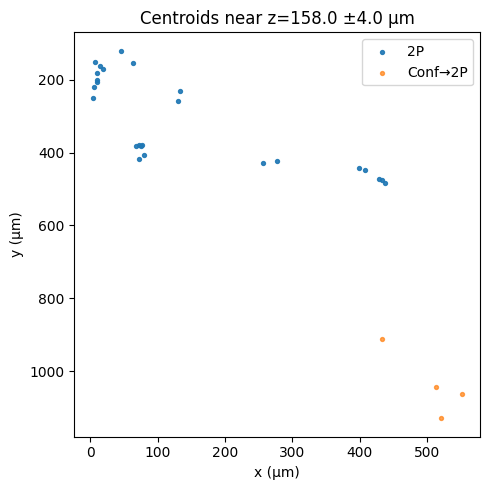

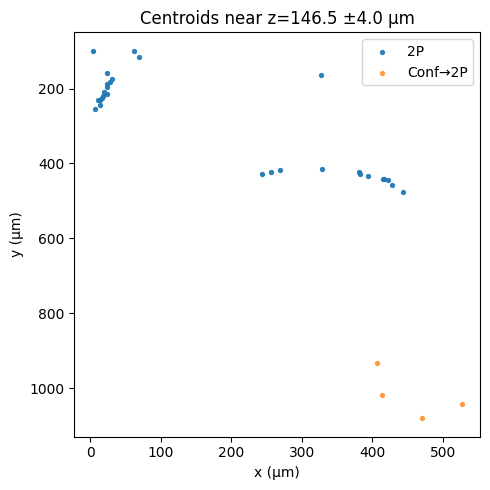

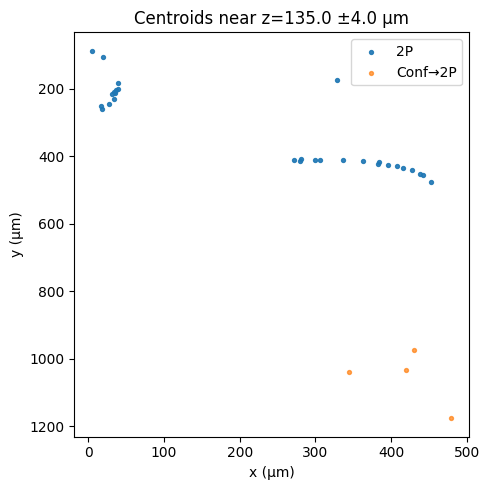

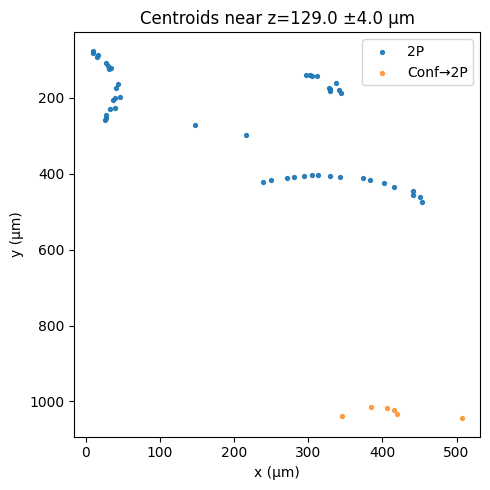

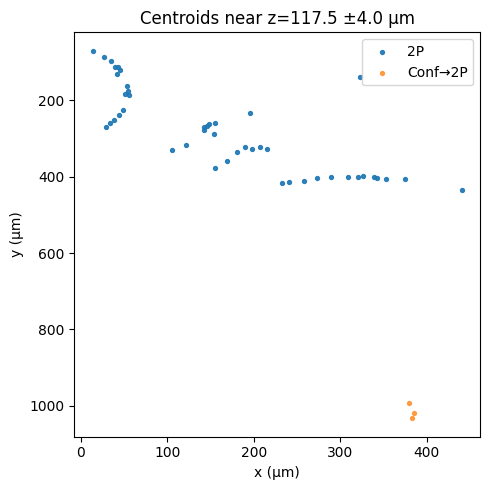

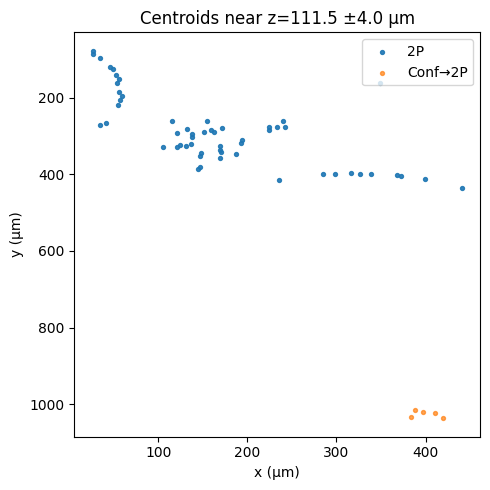

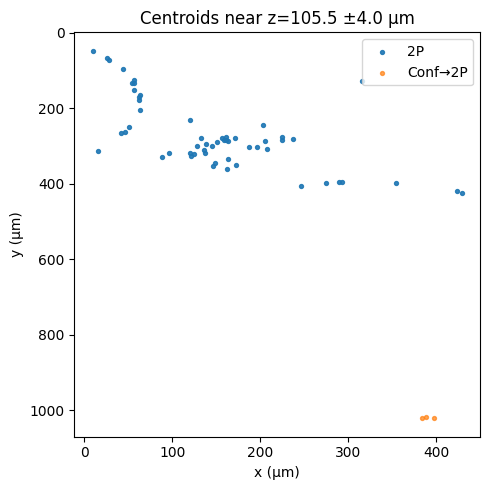

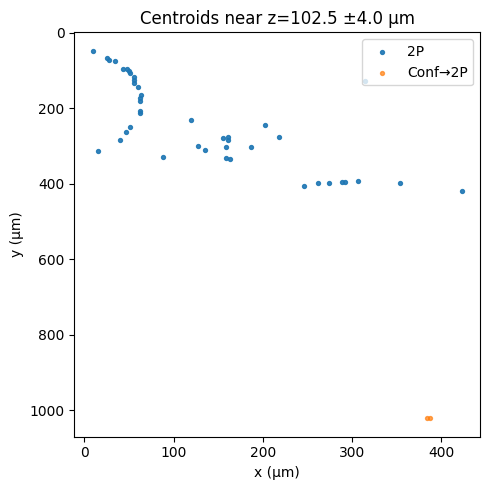

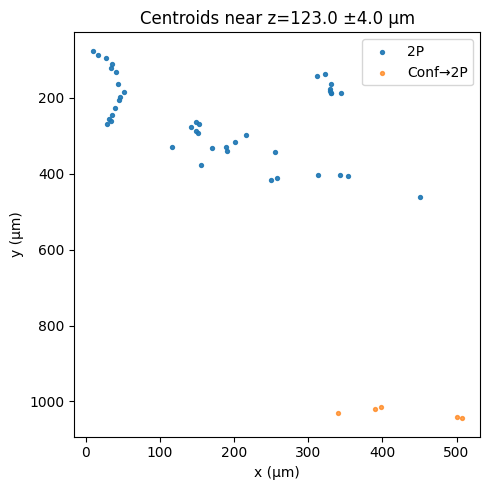

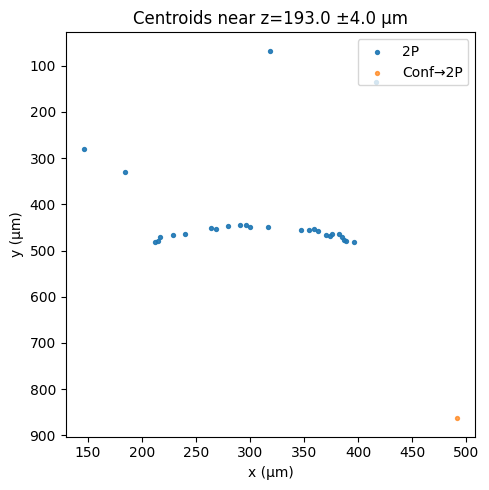

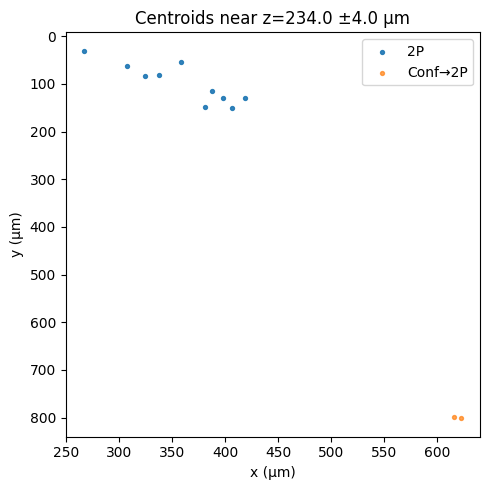

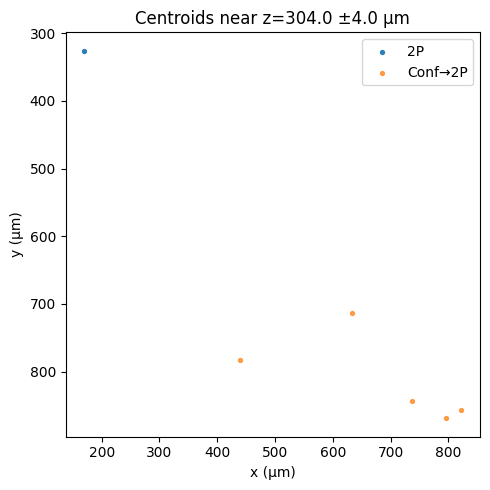

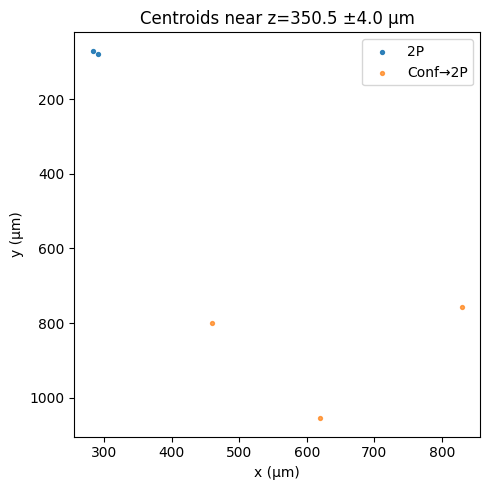

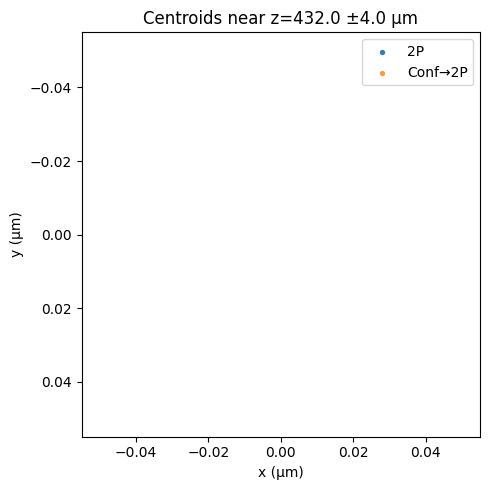

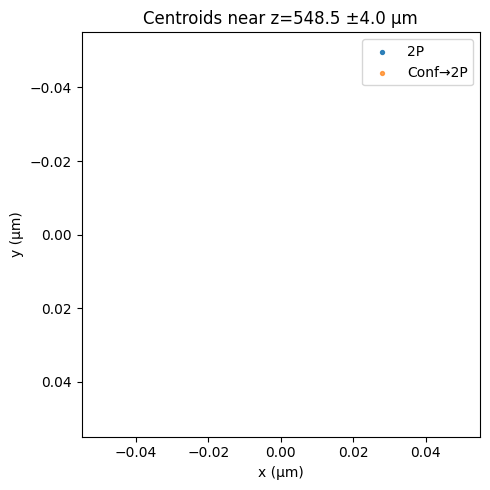

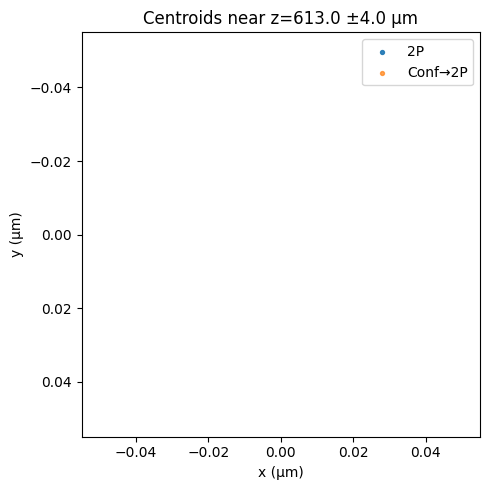

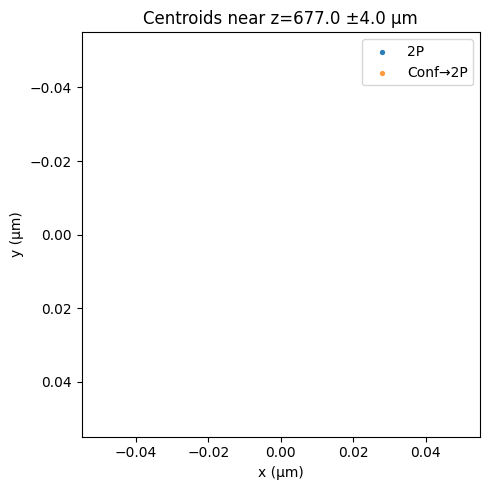

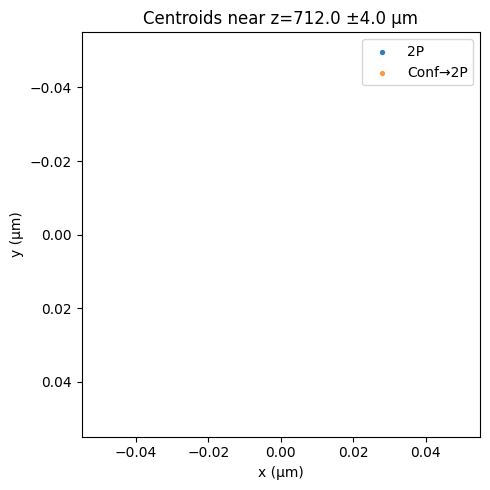

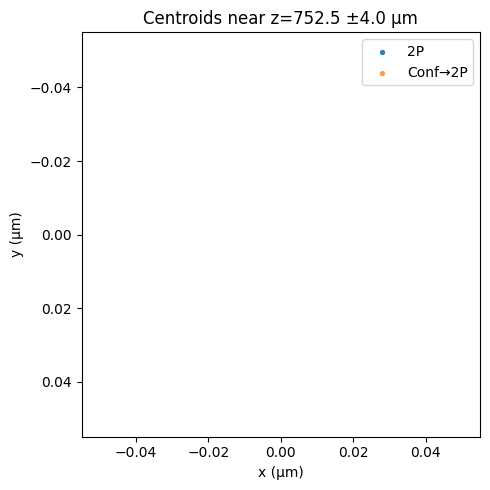

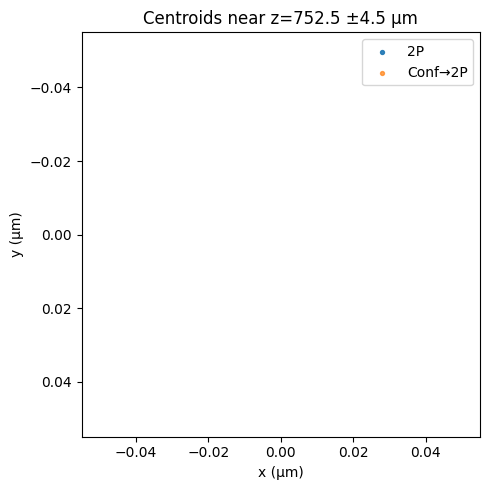

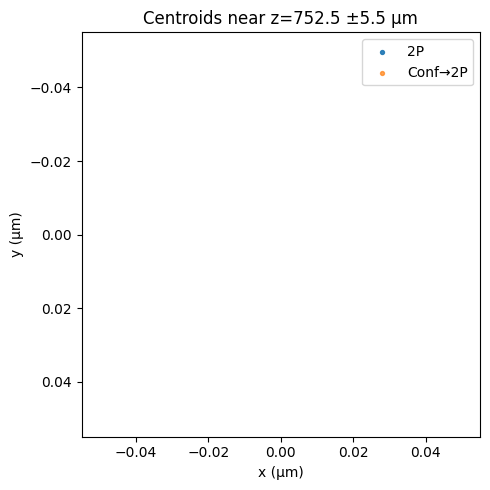

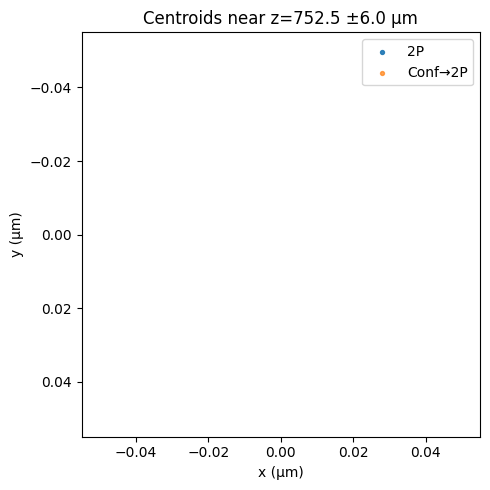

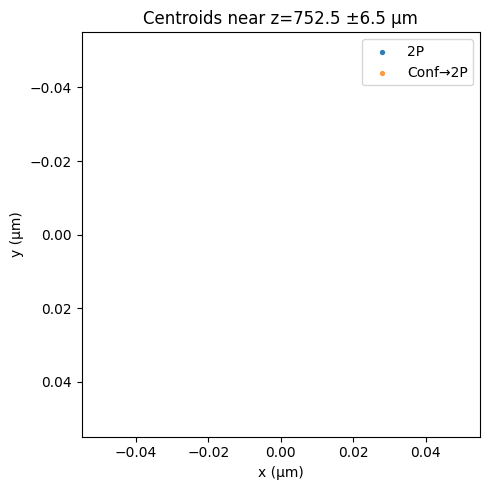

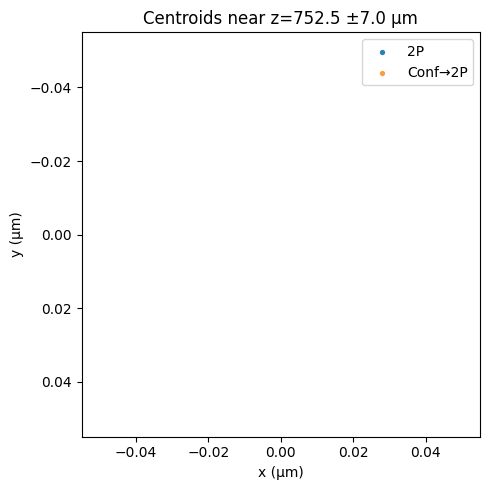

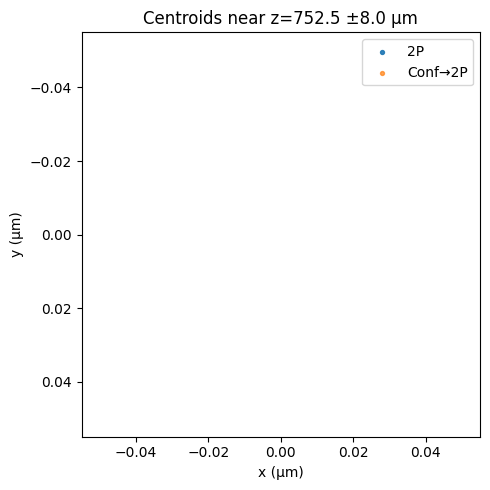

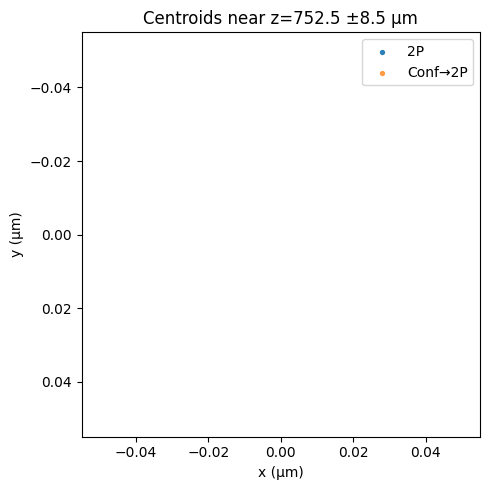

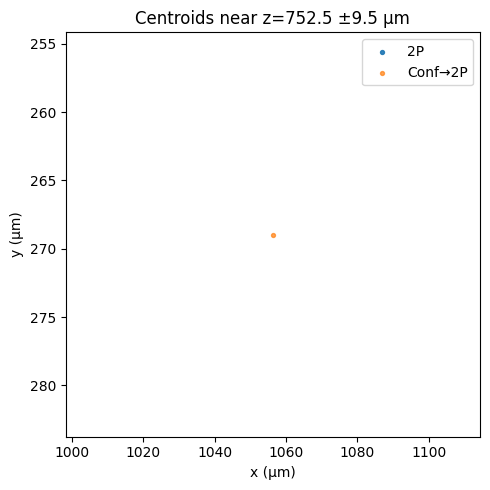

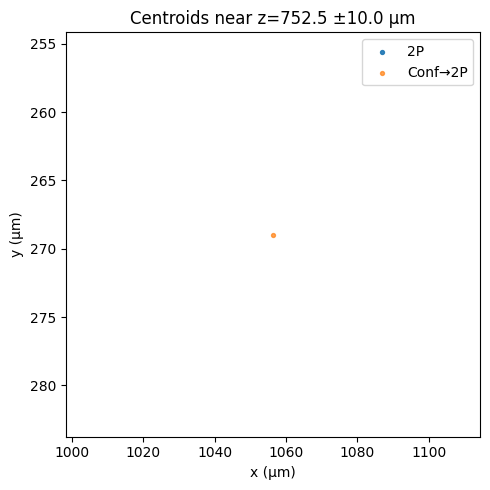

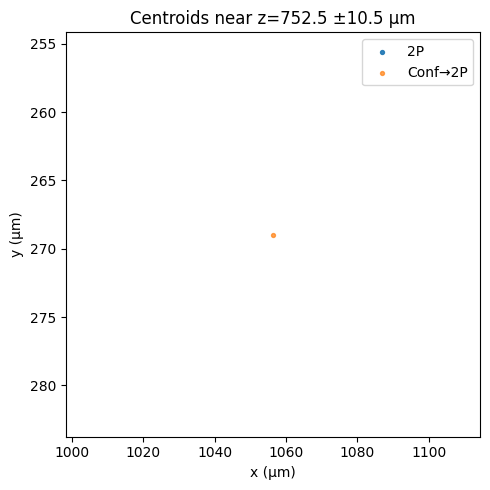

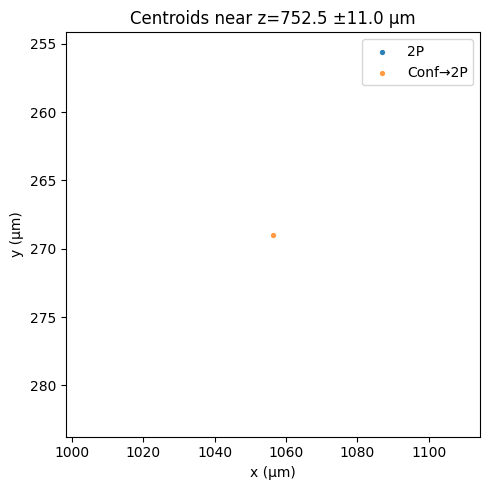

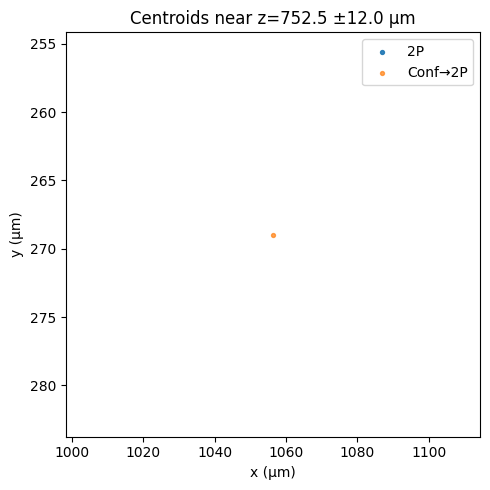

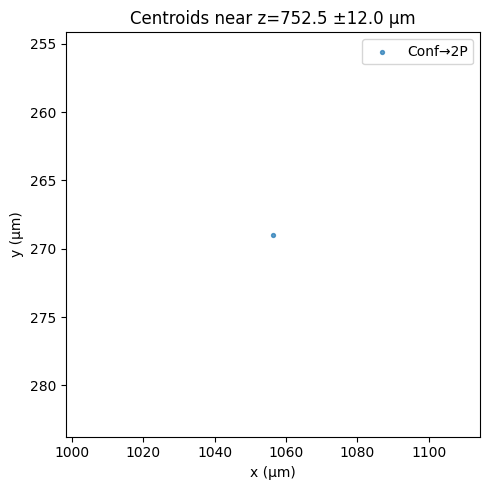

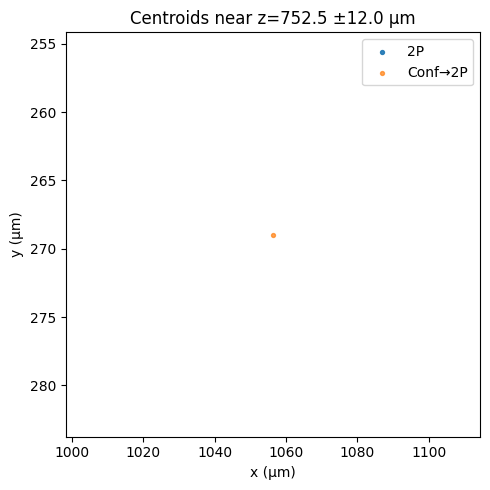

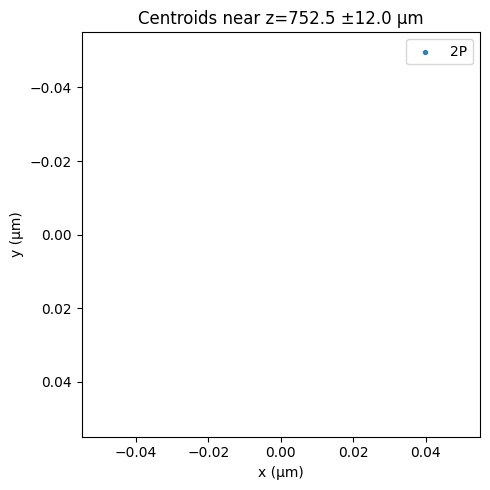

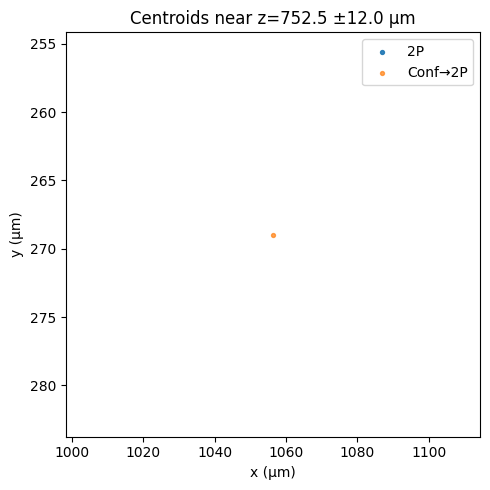

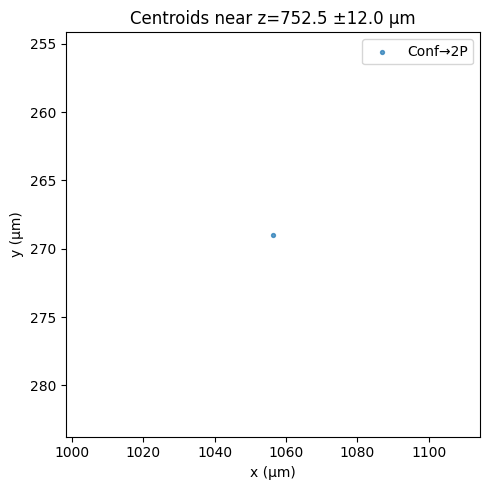

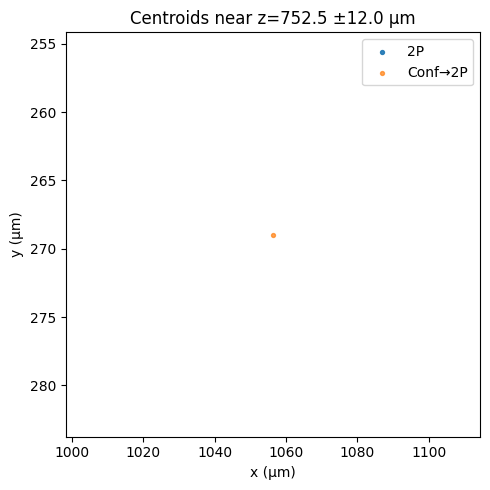

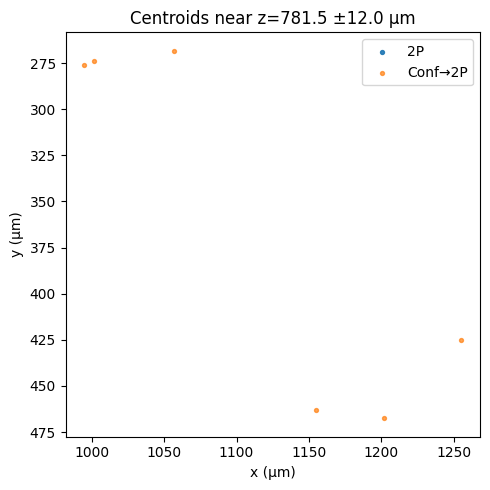

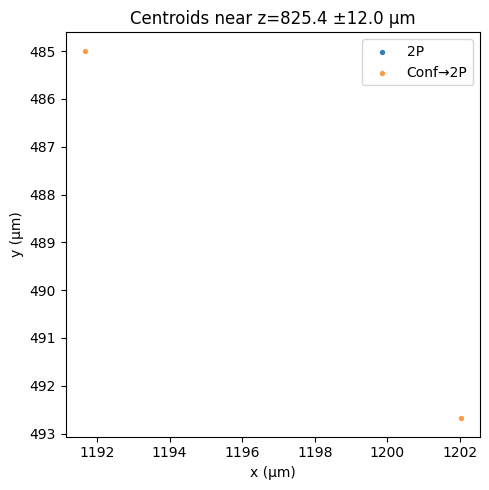

In [11]:
# Optional interactive viewer (requires ipywidgets).
if RESULT.confocal_dataset.spacing.ndim != 3:
    raise ValueError("Interactive slice viewer expects 3D stacks.")

try:
    from ipywidgets import interact, FloatSlider, Checkbox
except Exception as exc:
    raise RuntimeError("ipywidgets is required for the viewer.") from exc

P_twop = RESULT.twop_centroids_um
P_conf = RESULT.conf_centroids_in_twop_um

Z2, Y2, X2 = P_twop[:, 0], P_twop[:, 1], P_twop[:, 2]
Zc, Yc, Xc = P_conf[:, 0], P_conf[:, 1], P_conf[:, 2]

def _plot_slice(z_um=0.0, thickness_um=4.0, show_conf=True, show_2p=True):
    mask_2p = np.abs(Z2 - z_um) <= thickness_um
    mask_conf = np.abs(Zc - z_um) <= thickness_um
    fig, ax = plt.subplots(figsize=(5, 5))
    if show_2p:
        ax.scatter(X2[mask_2p], Y2[mask_2p], s=8, alpha=0.9, label="2P")
    if show_conf:
        ax.scatter(Xc[mask_conf], Yc[mask_conf], s=8, alpha=0.7, label="Conf→2P")
    ax.invert_yaxis()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    ax.set_title(f"Centroids near z={z_um:.1f} ±{thickness_um:.1f} µm")
    ax.legend(loc="upper right")
    fig.tight_layout()

interact(
    _plot_slice,
    z_um=FloatSlider(min=float(Zc.min()), max=float(Zc.max()), step=0.5, value=float(Zc.mean())),
    thickness_um=FloatSlider(min=0.5, max=20.0, step=0.5, value=4.0),
    show_conf=Checkbox(value=True, description="show Conf→2P"),
    show_2p=Checkbox(value=True, description="show 2P"),
)


In [ ]:
# Quick peek at random voxels from both stacks.
pd.concat([
    RESULT.confocal_dataset.sample_voxels(20, seed=0),
    RESULT.twop_dataset.sample_voxels(20, seed=1),
]).head()
